## Cell 0: Check for GPU Availability

Ensure that TensorFlow detects one or more GPUs. Run this cell in a GPU-enabled environment (e.g., Kaggle Kernels with GPU).
.


In [1]:
# Check GPU availability
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Import Libraries

We import necessary libraries including scikeras for wrapping our Keras model, and also import SimpleImputer (for missing value imputation). GPU-enabled training will be used if available.

In [2]:
!pip install scikeras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Install scikeras if needed
!pip install scikeras --quiet
from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Memory Optimization Function

This function attempts to reduce memory usage by downcasting numeric columns to smaller data types (e.g., float64 -> float32, int64 -> int32.


In [4]:
# Define memory optimization function
def reduce_memory_usage(df, verbose=True):
    """Downcasts numeric columns to reduce memory usage."""
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB "
              f"({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")
    return df

## Load and Optimize Data

We load our train/test data, apply the memory optimization function, and separate features/target. Adjust file names as needed for your environmen.


In [5]:
# Load and optimize data
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

print("Before memory optimization:")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

# Separate features and target from training data
X = train.drop(columns=['id', 'rainfall'])
y = train['rainfall']

# For test data, drop the id column and save the IDs for submission
X_test = test.drop(columns=['id'])
test_ids = test['id']

print("After optimization:")
print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

Before memory optimization:
Train shape: (2190, 13)
Test shape: (730, 12)
Memory usage reduced from 0.22 MB to 0.09 MB (56.7% reduction)
Memory usage reduced from 0.07 MB to 0.03 MB (54.1% reduction)
After optimization:
X shape: (2190, 11)
X_test shape: (730, 11)


## Define Preprocessing Pipelines

We create a dictionary of scalers to compare (none, standard, minmax, robust). If you prefer, you can remove or add more pipeline.


In [6]:
# Define preprocessing pipelines
preprocessors = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'raw': None
}

## Define Keras Model Function

We define a function that builds a DNN model. This will be used by the `KerasClassifier` wrapper. We'll allow hyperparameters like `optimizer`, `dropout_rate`, and `learning_rate` to be tune.


In [7]:
# Define the Keras model function
def create_dnn_model(optimizer='adam', dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Build optimizer with the specified learning rate
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
    return model

## Define KerasClassifier and Hyperparameter Grid

We use the `KerasClassifier` wrapper from scikeras, which integrates with scikit-learn. We set up a parameter grid (or distribution) for random search. Adjust the ranges to fit your problem constraint
We wrap our model with scikeras’ KerasClassifier. **Note:** For hyperparameters of the model-building function, we must use the prefix `model__` (and because the pipeline step is named `'dnn'`, we use `'dnn__model__'`)..


In [8]:
# Wrap the Keras model and define hyperparameter grid
dnn_wrapper = KerasClassifier(
    model=create_dnn_model,
    epochs=20,           # Default epochs; will be tuned
    batch_size=32,       # Default batch size; will be tuned
    verbose=0
)

# Hyperparameter grid using correct prefix "dnn__model__" for parameters passed to create_dnn_model.
param_dist = {
    'dnn__model__optimizer': ['adam', 'rmsprop'],
    'dnn__model__dropout_rate': [0.2, 0.3],
    'dnn__model__learning_rate': [1e-3, 1e-4],
    'dnn__epochs': [20, 30],
    'dnn__batch_size': [32, 64]
}

## Hyperparameter Tuning and Submission Generation (Robust Scaling Only)

We build a pipeline that first imputes missing values (using median strategy), then applies RobustScaler (our only option), and finally trains the DNN. We run RandomizedSearchCV (using a threading backend) for thorough tuning, re‑fit the best estimator, and generate test predictions. A submission file is saved.

In [9]:
# Run hyperparameter tuning and generate submissions for all preprocessing methods
from joblib import parallel_backend

results = []  # List to store tuning results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a directory for submission files
os.makedirs("submissions", exist_ok=True)

for prep_name, scaler in preprocessors.items():
    print(f"\n--- Preprocessing: {prep_name} ---")
    
    # Build pipeline: imputer -> (scaler if provided) -> DNN
    steps = []
    steps.append(('imputer', SimpleImputer(strategy="median")))
    if scaler is not None:
        steps.append((prep_name, scaler))
    steps.append(('dnn', dnn_wrapper))
    pipeline = Pipeline(steps)
    
    # Use threading backend to avoid pickling issues.
    with parallel_backend('threading', n_jobs=-1):
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_dist,
            n_iter=50,
            scoring='roc_auc',
            cv=cv,
            verbose=0,
            random_state=42,
            n_jobs=-1
        )
        search.fit(X, y)
    
    best_score = search.best_score_
    best_params = search.best_params_
    
    print(f"Best CV ROC AUC for {prep_name}: {best_score:.4f}")
    print("Best parameters:", best_params)
    
    # Re-fit the best estimator on the full training data to ensure it is fitted.
    best_estimator = search.best_estimator_
    best_estimator.fit(X, y)
    
    # Manually transform test data using all steps except the final DNN step
    X_test_transformed = best_estimator[:-1].transform(X_test)
    # Then call predict_proba on the DNN step
    test_preds = best_estimator.named_steps['dnn'].predict_proba(X_test_transformed)[:, 1]
    
    # Save the submission file for this preprocessing method
    sub_filename = f"submissions/{prep_name}_dnn_submission.csv"
    sub_df = pd.DataFrame({'id': test_ids, 'rainfall': test_preds})
    sub_df.to_csv(sub_filename, index=False)
    print(f"Submission file saved: {sub_filename}\n")
    
    # Record results for later comparison.
    results.append({
        'preprocessing': prep_name,
        'best_auc': best_score,
        'best_params': best_params,
        'submission_file': sub_filename
    })


--- Preprocessing: standard ---
Best CV ROC AUC for standard: nan
Best parameters: {'dnn__model__optimizer': 'adam', 'dnn__model__learning_rate': 0.001, 'dnn__model__dropout_rate': 0.2, 'dnn__epochs': 20, 'dnn__batch_size': 32}
Submission file saved: submissions/standard_dnn_submission.csv


--- Preprocessing: minmax ---
Best CV ROC AUC for minmax: nan
Best parameters: {'dnn__model__optimizer': 'adam', 'dnn__model__learning_rate': 0.001, 'dnn__model__dropout_rate': 0.2, 'dnn__epochs': 20, 'dnn__batch_size': 32}
Submission file saved: submissions/minmax_dnn_submission.csv


--- Preprocessing: robust ---
Best CV ROC AUC for robust: nan
Best parameters: {'dnn__model__optimizer': 'adam', 'dnn__model__learning_rate': 0.001, 'dnn__model__dropout_rate': 0.2, 'dnn__epochs': 20, 'dnn__batch_size': 32}
Submission file saved: submissions/robust_dnn_submission.csv


--- Preprocessing: raw ---
Best CV ROC AUC for raw: nan
Best parameters: {'dnn__model__optimizer': 'adam', 'dnn__model__learning_rat

## Compare Results

We create a DataFrame from the results and sort by the best AUC score to see which preprocessing pipeline + hyperparameters performed bes.


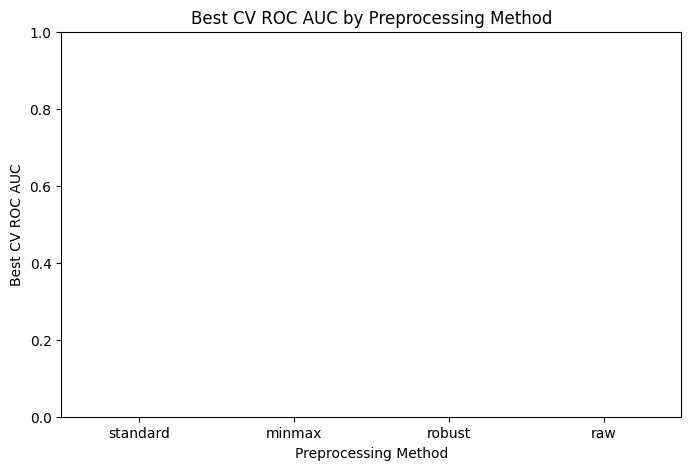

In [10]:
# Create a bar plot to compare best CV ROC AUC scores
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='best_auc', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='preprocessing', y='best_auc', data=results_df, palette='viridis')
plt.title("Best CV ROC AUC by Preprocessing Method")
plt.xlabel("Preprocessing Method")
plt.ylabel("Best CV ROC AUC")
plt.ylim(0.0, 1.0)
plt.show()

## Copy Best Scoring Submission as submission.csv

From the tuning results, we identify the best scoring submission and copy that file to "submission.csv" (the name required by the competition). All other submission file names remain unchanged..


In [11]:
# Copy the best scoring submission to "submission.csv"
import shutil

# Filter out any candidates with NaN scores and choose the best candidate
valid_results = results_df[results_df['best_auc'].notna()]
if valid_results.empty:
    raise ValueError("No valid submission found with a non-NaN ROC AUC score.")

best_result = valid_results.iloc[0]
best_submission_file = best_result['submission_file']

shutil.copy(best_submission_file, 'submission.csv')
print(f"Best scoring submission ({best_submission_file}) copied as 'submission.csv'")

ValueError: No valid submission found with a non-NaN ROC AUC score.

## Retrain Final Models and Generate Final Submissions

Optionally, you can retrain final models using the best hyperparameters from each pipeline on the entire training data and generate final submissions. This cell demonstrates that step.

In [ ]:
# # Retrain final models with best parameters and generate final submissions
# for idx, row in results_df.iterrows():
#     prep = row['preprocessing']
#     best_params = row['best_params']
#     print(f"Retraining final model with preprocessing: {prep}")
    
#     steps = []
#     steps.append(('imputer', SimpleImputer(strategy="median")))
#     if prep in preprocessors and preprocessors[prep] is not None:
#         steps.append((prep, preprocessors[prep]))
#     steps.append(('dnn', dnn_wrapper.set_params(**best_params)))
#     final_pipeline = Pipeline(steps)
    
#     final_pipeline.fit(X, y)
#     final_preds = final_pipeline.predict_proba(X_test)[:, 1]
    
#     final_sub_filename = f"submissions/final_{prep}_dnn_submission.csv"
#     final_sub_df = pd.DataFrame({'id': test_ids, 'rainfall': final_preds})
#     final_sub_df.to_csv(final_sub_filename, index=False)
#     print(f"Final submission saved: {final_sub_filename}\n")

## Conclusion

- **Memory Optimization**: We reduced memory usage by downcasting numeric columns.
- **Missing Value Handling**: A SimpleImputer (median strategy) is applied to ensure no NaN values persist.
- **Preprocessing Pipelines**: Submissions were generated for all preprocessing methods (Standard, MinMax, Robust, Raw).
- **GPU Acceleration**: The DNN is configured to run on GPU if available.
- **Thorough Hyperparameter Tuning**: Using RandomizedSearchCV (50 iterations over 5-fold CV), we tuned optimizer, dropout rate, learning rate, epochs, and batch size.
- **Graphical Comparison**: A bar plot shows the best CV ROC AUC scores for each preprocessing method.
- **Final Submission**: The highest scoring submission is explicitly copied to **submission.csv**.

This code is designed for a competitive setting—feel free to adjust hyperparameter ranges, iterations, and preprocessing options for further improvements. Happy modeling and best of luck in the competition!
